# III - Modélisation : 

Le but de cette partie est de tenter d'obtenir des résultats pertinents et cohérents à l'aide d'un modèle bien choisie. On rappelle que notre travail se concentre sur un problème de classification binaire portant en tout sur 5 variables, les `radiéi`, $i \in \{1,2,3,4,5\}$, valant 1 si une entreprise a été radiée au cours de l'année i après la création, et 0 sinon. L'idée est la suivante :

Afin de prendre en compte les spécificité de chaque variables cibles, nous nous donnons 5 modèles sur lesquels l'entrainement se fera sur les data sets a priori pa rapport à `radiéi`.
C'est ainsi 5 prédictions que l'on obtiendra.
Le choix d'un modèle de type ensemble gradient boosting utilisant des arbres est adapté dans notre cas. D'une part, ces modèles sont robustes au sur-apprentissage et peuvent être entrainé sur des grands jeux de données, avec beaucoup de variables. D'autre part, des modèles comme XGBoost sont très rapide à entrainer et à valider par cross-validation. Enfin, selon les benchmarks connus, ce sont les meilleurs pour des problèmes de classification. En revanche, il est difficile d'interpréter les résultats, chose qui nous concerne peu ici.
Nous choisirons ici Xgboost pour ses performances bien connus.

C'est donc au total 5 classifications à l'aide d'xgb que l'on fera.

### Les métriques utiles pour l'évaluation des performances du modèle en lien avec notre problématique "métier" : 

Souvent en classification binaire, l'auc est la métrique de premier plan. Celle-çi correspond à l'air sous la courbe roc, courbe sur laquelle chaque point représente le couple (FN,TP) (TP == vrai positif / FN == faux négatif). Plus l'on se situe en haut à droite de cette courbe, c'est-à-dire au point $(0,1)$, plus le modèle discrimine bien les deux classes. L'idéal est donc d'obtenir comme courbe roc le carré unité, correspondant donc à un auc de 1. 
Nous regarderons donc attentivement cette métrique, notamment sur la partie selection de modèle.

Mais ce n'est pas la seule que nous devons regarder. La précision, définie comme la proportion de vrais positives parmi les positifs prédit par le modèle pourrait aussi être regardée. Cependant, on peut partir du principe suivant concernant notre problème : on peut considérer que les personnes souhaitant savoir si leur projet d'entreprise pourrait connaitre une radiation, et de manière plus concrète pour une personne réelle, si leur projet d'entreprise pourrait connaitre un "échec", sont plutôt averse au risque, et que c'est d'ailleurs la raison qui les a poussé à faire appel à un tel outils. 
Par conséquent, si notre modèle prédit pour ces personnes que leur projet à des chances de ne pas "marcher", et que leur projet est de manière absolue un projet porteur d'avenir, qui ne connaitrait pas d'échec, cela est moins grave que le cas contraire, c'est-à-dire le cas où le modèle ne prédirait pas "d'échec", alors que le projet porte en soi l'échec.
En termes de métriques, si l'on s'accorde sur ce principe "métier", il est moins problématique d'avoir un certain nombre de faux positifs plutôt que d'avoir un certain nombre de faux négatifs. Autrement dit, il est plus important pour nous de porter regard au recall, définie que la proportion de positif effectivement prédit comme positif par le modèle, plutôt que de porter attention à la précision. 

Un bon moyen d'évaluer cela est regarder le score $f_\beta$, correspondant à une moyenne harmonique entre recall et précision dans le cas $\beta =1$, qui donne une importance de taille $\beta >0$ au recall (si $\beta <1$, la précision est favorisé). Pour notre problème, nous nous concentrerons sur $\beta \in \{2,3\}$, donnant ainsi plus d'important au recall.

### Le problème de sous-représentation de la classe positive dans nos données : 

Ce problème est natif de nos données : il reste tout de même assez rare qu'une entreprise soit radiée au cours des années suivant sa création. 
Ce déséquilibre est problématique pour un modèle de classification. Pour répondre à cela, plusieurs solutions existent. Une solution très utilisé en risque de crédit, par les banques notamment, faisant face à ce type de déséquilibre, est la technique Smote, consistant à ré-échantilloner le data set d'entrainement en favorisant artificiellement la classe pauvre. Une autre consiste à faire l'inverse, en sous-estimant artificiellement la classe riche.
La solution que nous retenons ici est d'utiliser l'hyperparamètre scale_pos_weight permettant de faire face aux classes desquilibrés. Il doit être réglé souvent comme le rapport entre le nombre de negatifs et postifs. L'avantage de cette méthode est qu'elle est simple, et ne modifie pas directement les data sets d'entrainement.

### Le problème d'un potentielle sur-apprentissage  : 

Afin de lutter contre cela, nous sélectionnerons de manière automatique et indirect les variables d'intérêts grâce au critère de pénalisation l1 (alpha dans xgb), donnant moins d'importance aux feuilles complexes des arbres. 

Concernant l'entrainement, nous pourrons procéder par cross-validation sur les data sets d'entrainement, en sélectionnant comme traditionnellement 5 strats. On peut également faire une recherche par grille et cross-validation des hyperparamètres des modèles. 

Les performances des modèles seront finalement évalués sur le test.
### La prédiction, en pratique :

Comme nos variables vont nécessiter un certain pré-traitement afin de pouvoir fournir une prédiction, nous construirons un pipeline adapté.
Les modèles retenus seront sauvegardés pour pouvoir les réutiliser facilement.

---------

Le cadre étant posé, place à la pratique : 

In [109]:
from data.load_idf_10_24 import load_base_model, get_df_i
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [62]:
#Récupération des données issues de l'analyse depuis le module load_idf_10_24
data = load_base_model()

Data Frame idf_10_24MODEL récupéré depuis S3


In [63]:
#Correction des valeurs manquantes pour montantCapital à 0 et supression des doublons pour siren*
data["montantCapital"] = data["montantCapital"].apply(lambda x : 0 if x == "non-disp" else float(x))
data = data.drop_duplicates(subset=["siren"])

In [64]:
dfs = get_df_i(data)

In [65]:
#Sélections des variables candiates : 
var_cand = ["cp","taille_ville","mean_age","nb_associe","nb_local_concurrents",
"revCommune","sumxp","sumxp_rad","sumxp_ape","codeAPE","montantCapital","personneMorale","micro","revDep"]

In [66]:
#train-test-split pour chaque data frame | random_state = 0
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

X_train = []
y_train = []
X_test = []
y_test = []

for df,var in zip(dfs,var_cible) : 
    X = df[var_cand]
    Y = df[var]

    x_tr, x_t, y_tr, y_t = train_test_split(X,Y,stratify=Y,test_size=0.15,random_state=0,shuffle=True)
    X_train.append(x_tr)
    X_test.append(x_t)
    y_train.append(y_tr)
    y_test.append(y_t)


In [67]:
    ############################################
# Définition du pipeline de pré-traitement #
    ############################################

colonnes_num = ["mean_age","nb_associe","nb_local_concurrents",
"revCommune","sumxp","sumxp_rad","sumxp_ape","montantCapital","revDep"]
colonnes_cat = ["cp","taille_ville","codeAPE","personneMorale","micro"]

#Pré-traitement pour standard scaler et transformation des cat en one hot
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonnes_num),
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'), colonnes_cat)
    ]
)


In [68]:

model = XGBClassifier(
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective = "binary:logistic",
    eval_metric="auc",
    random_state=0,
)

pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', model)
])

In [69]:
param_grid = {
    "model__max_depth": [3, 4, 6],
    "model__alpha": [0,0.5,1],
    "model__n_estimators": [200,300,400],
    "model__scale_pos_weight": [30,40,50]
}

search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0
)


In [70]:
best_models = []

for x_tr, y_tr, in zip(X_train,y_train):
    search.fit(x_tr,y_tr)
    best_models.append(search.best_estimator_)

/opt/python/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/opt/python/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/opt/python/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/opt/python/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/opt/python/lib/python3.13/site-packages

In [78]:
#Sauvegarde des 5 modèles obtenues
for i in range(5):
    model_name = f"xgb_radié{i+1}.pkl"
    joblib.dump(best_models[0], model_name)

In [79]:
#Pour les charger dans une autre utilisation, voila la ligne à entrer
"""
pipeline_loaded = joblib.load("pipeline_xgb.pkl")
"""

'\npipeline_loaded = joblib.load("pipeline_xgb.pkl")\n'

In [ ]:
#Entrainement des modèles finaux
for i in range(5):
    best_models[i].fit(X_train[i],y_train[i])

In [105]:
best_seuils = []

for i in range(5):

    y_prob = best_models[i].predict_proba(X_test[i])[:,1]

    #Selection du seuil optimal selon f2 (favorise le recall sur la précision) 
    th = np.linspace(0,1,1000)
    f2 = []

    if i < 3:
        beta = 3
    elif i == 5:
        beta = 1.5
    else: 
        beta = 2.5

    for seuils in th:
        y_pred = [1 if p >= seuils else 0 for p in y_prob]
        f2_it = fbeta_score(y_test[i],y_pred,beta=beta)
        f2.append(f2_it)

    max_index = f2.index(np.max(f2))
    best_th = th[max_index]

    best_seuils.append(best_th)

In [110]:
#Sauvegarde des seuils dans un fichier json
with open("seuils_proba_xgb.json", "w") as f:
    json.dump(best_seuils, f)

In [ ]:
#Pour les chargés dans une autre utilisation
"""
with open("seuils_proba_xgb.json", "r") as f:
    liste_lue = json.load(f)
"""

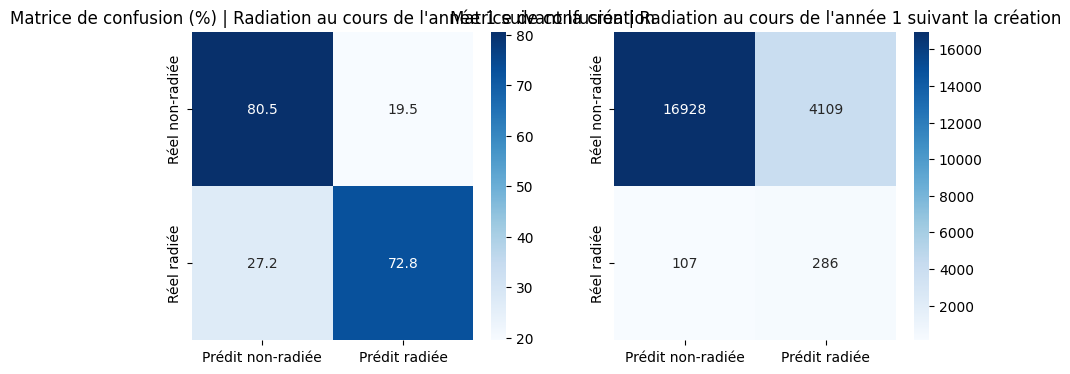

auc année 1:  0.8627538708305166
f1 année 1:  0.11946532999164577
f3 année 1:  0.3605648008068583
accuracy année 1:  0.8032664489034065
precision année 1:  0.06507394766780432
recall année 1:  0.727735368956743


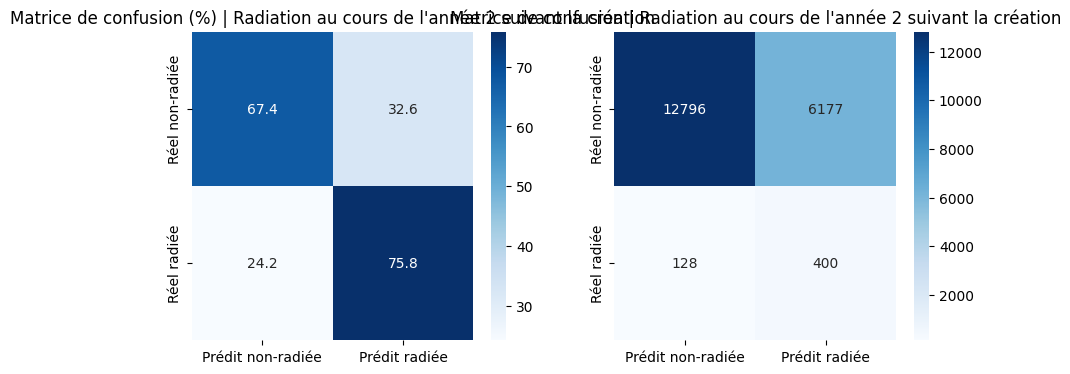

auc année 2:  0.7799159671079636
f1 année 2:  0.11259676284306826
f3 année 2:  0.3530761761850119
accuracy année 2:  0.6766832470129737
precision année 2:  0.060818002128630075
recall année 2:  0.7575757575757576


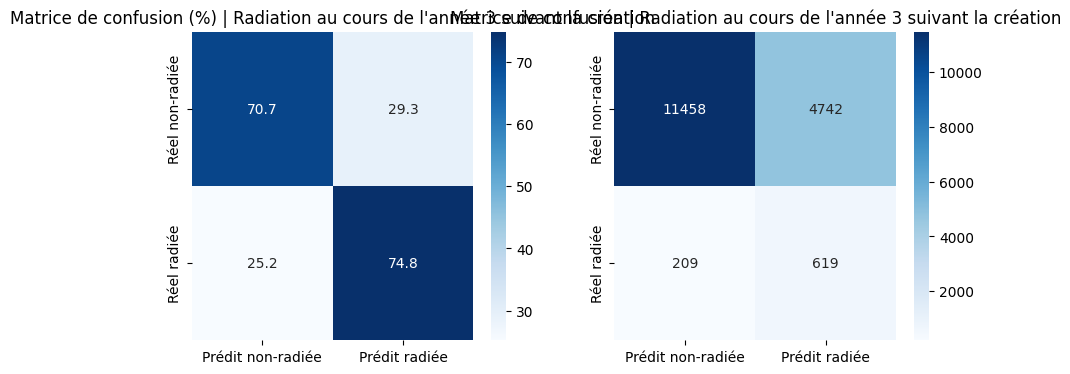

auc année 3:  0.792194973757977
f1 année 3:  0.20003231539828728
f3 année 3:  0.48310309841567156
accuracy année 3:  0.7092435987784825
precision année 3:  0.11546353292296213
recall année 3:  0.7475845410628019


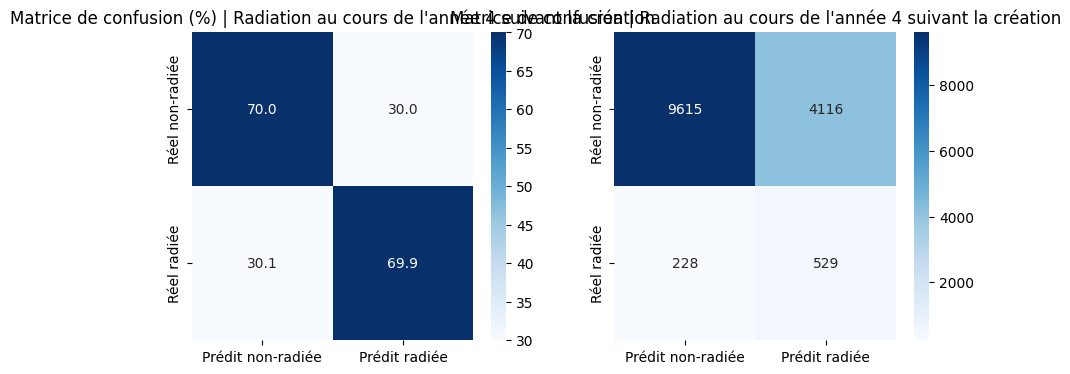

auc année 4:  0.766979124366111
f1 année 4:  0.19585338763420956
f2.5 année 4:  0.40903879482735633
accuracy année 4:  0.7001656543346217
precision année 4:  0.11388589881593111
recall année 4:  0.6988110964332893


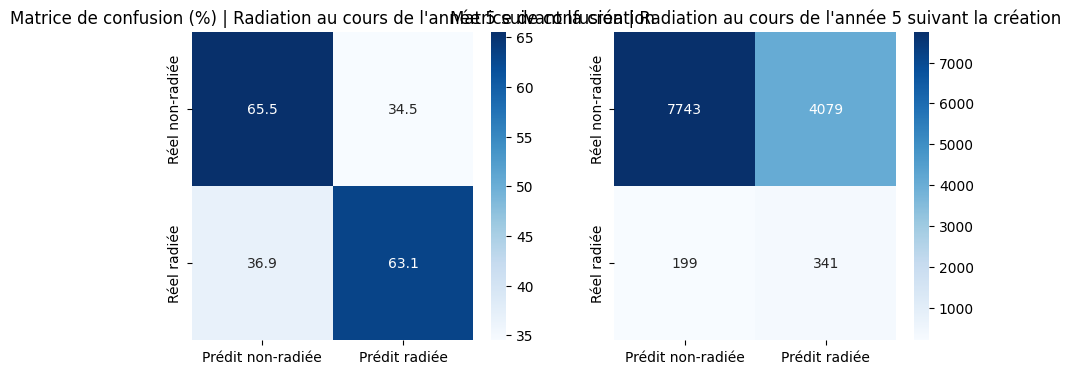

auc année 5:  0.6946646083572999
f1 année 5:  0.1375
f2.5 année 5:  0.3171584348941629
accuracy année 5:  0.6539394919915871
precision année 5:  0.07714932126696833
recall année 5:  0.6314814814814815


In [107]:
#Matrices de confusions et principales métriques
for i in range(5):

    th = best_seuils[i]

    y_prob = best_models[i].predict_proba(X_test[i])[:,1]

    y_pred = [1 if p >= th else 0 for p in y_prob]

    # Création de la matrice de confusion
    cm = confusion_matrix(y_test[i], y_pred)

    cm = confusion_matrix(y_test[i], y_pred)

    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100 

    title1 = f"Matrice de confusion (%) | Radiation au cours de l'année {i+1} suivant la création"
    title2 = f"Matrice de confusion | Radiation au cours de l'année {i+1} suivant la création"

    fig, ax = plt.subplots(1,2,figsize=(10,4))

    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=["Prédit non-radiée", "Prédit radiée"],
                yticklabels=["Réel non-radiée", "Réel radiée"], ax = ax[0])
    ax[0].set_title(title1)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Prédit non-radiée", "Prédit radiée"],
                yticklabels=["Réel non-radiée", "Réel radiée"], ax = ax[1])
    ax[1].set_title(title2)

    plt.show()


    if i < 3:
        beta = 3
        f = "f3"
    elif i == 5:
        beta = 1.5
        f = "f1.5"
    else: 
        beta = 2.5
        f = "f2.5"


    print(f"auc année {i+1}: ", roc_auc_score(y_test[i],y_prob))
    print(f"f1 année {i+1}: ", f1_score(y_test[i],y_pred))
    print(f"{f} année {i+1}: ", fbeta_score(y_test[i],y_pred,beta=beta))
    print(f"accuracy année {i+1}: ", accuracy_score(y_test[i],y_pred))
    print(f"precision année {i+1}: ", precision_score(y_test[i],y_pred))
    print(f"recall année {i+1}: ", recall_score(y_test[i],y_pred))